# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Prepare-Functions" data-toc-modified-id="Prepare-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare Functions</a></div><div class="lev1 toc-item"><a href="#Algorithm" data-toc-modified-id="Algorithm-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Algorithm</a></div><div class="lev1 toc-item"><a href="#Check-output" data-toc-modified-id="Check-output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check output</a></div>

参考: https://github.com/aidiary/PRML/blob/master/ch9/gmm_em.py

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from pylab import *
import matplotlib.mlab as mlab

In [3]:
os.chdir("/home/3928941380/Desktop/Temp/Topic_Model/EM/Python/")

In [4]:
K = 2 # Number of distribution (fixed)

# Prepare Functions

In [5]:
def gaussian(x, mean, cov):
    """多変量ガウス関数"""
    temp = - 0.5 * np.dot(np.dot(x - mean, np.linalg.inv(cov)), x - mean)
    return ( 1 / ((2 * np.pi) ** (x.size/2.0)) ) * (  1 / (np.linalg.det(cov) ** 0.5)  ) * np.exp(temp)

# np.linalg: 線形代数用

In [6]:
def likelihood(X, mean, cov, pi): # PRML Equation (9.36)
    """対数尤度関数"""
    summation = 0.0
    for n in range(len(X)):
        temp = 0.0
        for k in range(K):
            temp += pi[k] * gaussian(X[n], mean[k], cov[k])
        summation += np.log(temp)
    return summation

# Algorithm

In [7]:
# 訓練データをロード
data = np.genfromtxt("faithful.txt")
X = data[:, 0:2]
N = len(X)    # データ数

# 初期化
init_mu = array([data[:, 0].mean(), data[:, 1].mean()])
mean = array([1.1*init_mu, 0.9*init_mu])

cov = zeros( (K, 2, 2) ) # Return a new array of given shape and type, filled with zeros.
for k in range(K):
    cov[k] = np.identity(K)

pi = ones(2)  / K

# 負担率の空配列を用意
gamma = zeros( (N, K) )

# 対数尤度の初期値を計算
like = likelihood(X, mean, cov, pi)


turn = 0

while True:
    print(turn, like)
    

    # E-step : 現在のパラメータを使って、負担率を計算
    for n in range(N):
        # 分母はkによらないので最初に1回だけ計算
        denominator = 0.0
        for j in range(K):
            denominator += pi[j] * gaussian(X[n], mean[j], cov[j])
        # 各kについて負担率を計算
        for k in range(K):
            gamma[n][k] = pi[k] * gaussian(X[n], mean[k], cov[k]) / denominator
            
    # M-step : 現在の負担率を使って、パラメータを再計算
    for k in range(K):
        # Nkを計算する
        Nk = 0.0
        for n in range(N):
            Nk += gamma[n][k]

        # 平均を再計算
        mean[k] = zeros( (1, K) )
        for n in range(N):
            mean[k] += gamma[n][k] * X[n]
        mean[k] /= Nk

        # 共分散を再計算
        cov[k] = zeros( (K, K) )
        for n in range(N):
            temp = X[n] - mean[k]
            cov[k] += gamma[n][k] * matrix(temp).reshape(2, 1) * matrix(temp).reshape(1, 2)  # 縦ベクトルx横ベクトル
        cov[k] /= Nk

        # 混合係数を再計算
        pi[k] = Nk / N

    # 収束判定
    new_like = likelihood(X, mean, cov, pi)
    diff = new_like - like
    if diff < 0.001:
        break
    like = new_like
    turn += 1

0 -9622.82437634
1 -1165.62748684
2 -1147.84706464
3 -1136.69598237
4 -1130.77573945
5 -1130.28104294
6 -1130.26482837


# Check output

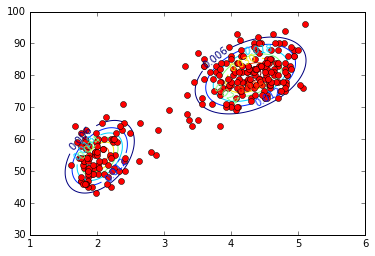

In [8]:
x = np.linspace(1.0, 6.0, 300)
y = np.linspace(30, 100, 300)
X, Y = np.meshgrid(x,y)

# 分散共分散行列の対角要素はsigmax^2, sigmay^2 であることに注意してbivariate normalを作る
k=0
Z1 = mlab.bivariate_normal(X, Y, sigmax=np.sqrt(cov[k,0,0]), sigmay=np.sqrt(cov[k,1,1]), mux=mean[k,0], muy=mean[k,1], sigmaxy=np.sqrt(cov[k,0,1]))

k=1
Z2 = mlab.bivariate_normal(X, Y, sigmax=np.sqrt(cov[k,0,0]), sigmay=np.sqrt(cov[k,1,1]), mux=mean[k,0], muy=mean[k,1], sigmaxy=np.sqrt(cov[k,0,1]))

Z = pi[0] * Z1 + pi[1] * Z2

CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)

fp = open("faithful.txt")
data_x = []
data_y = []
for row in fp:
    data_x.append(float((row.split()[0])))
    data_y.append(float((row.split()[1])))
fp.close()
plt.plot(data_x, data_y, "ro")

plt.show()